In [61]:
import numpy as np
import scipy
import time
from sklearn.datasets import make_blobs, make_moons
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [62]:
FROM_DATASET = True
USE_LIPSCHITZ_CONSTANT = True
OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM = False
OUTPUT_STEP = 0.1
N_SAMPLES = 4200
PARTITION = int(N_SAMPLES*0.1)
NUM_ITERS = 60
EPSILON = 1e-5
PLOT_DPI = 150
OPTIMIZE_RANDOM = False

#diabetes, smoking
DATABASE = 'smoking'

In [63]:

if not FROM_DATASET:
    # Set random seed for reproducibility
    np.random.seed(420)

    # Create dataset with 10,000 points and 2 clusters
    #X, y = make_blobs(n_samples=N_SAMPLES, centers=2, cluster_std=1.5)
    X, y = make_moons(n_samples=N_SAMPLES, noise=0.2, random_state=420)
    y = np.where(y == 0, -1, y)

    # Print the shapes of X and y
    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)

    # Create scatter plot
    plt.scatter(X[:, 0], X[:, 1], c=y)

    # Add axis labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Scatter Plot of 10,000 Points with 2 Clusters')

    # Show the plot
    plt.show()

else:

    if DATABASE == "diabetes":
        data = np.genfromtxt('diabetes.csv', delimiter=',', skip_header=1)
        X = data[:, :-1]
        y = data[:, -1]
        y = np.where(y == 0, -1, y)
    
    if DATABASE == "smoking":
        data = np.genfromtxt('smoking.csv', delimiter=',', skip_header=1)
        X = data[:, : -1]
        y = data[:, -1]

        columns_to_remove = [0, 1, 23, 25]
        X = np.delete(X, columns_to_remove, axis=1) 
        X = X[:10000]
        y = np.where(y == 0, -1, y)
        y = y[:10000]


In [64]:
print("Dataset Lenght")
print("Tot: " + str(len(X)) + ", lab: " + str(PARTITION) + ", unlab: " + str(len(X)-PARTITION))

X.shape

Dataset Lenght
Tot: 10000, lab: 420, unlab: 9580


(10000, 22)

In [65]:
import collections

# Points initialization
labeled_X = np.array(X[:PARTITION])
unlabeled_X = np.array(X[PARTITION:])

unlabeled_X.shape

# Label initialization
y_labeled = np.array(y[:PARTITION])
collections.Counter(y_labeled)

y_unlabeled_target = np.array(y[PARTITION:])

y_unlabeled_initial = np.random.choice([-1,1], size = (len(unlabeled_X,)))

In [66]:
# Check y
print("Target: " + str(len(y_unlabeled_target)))
print("Initial: " + str(len(y_unlabeled_initial)))

Target: 9580
Initial: 9580


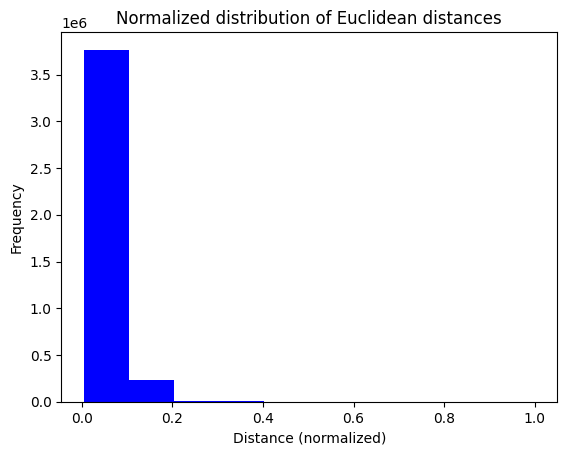

(420, 9580)

In [67]:
import math
import seaborn as sns

labeled_distances = cdist(labeled_X, unlabeled_X)

# Normalize the distances
max_distance = np.max(labeled_distances)
labeled_normalized_distances = labeled_distances / max_distance

# Plot the normalized distribution of distances using a histogram
plt.hist(labeled_normalized_distances.flatten(), bins=10, color='blue')

# Set the x and y axis labels and title
plt.xlabel('Distance (normalized)')
plt.ylabel('Frequency')
plt.title('Normalized distribution of Euclidean distances')

# Show the plot
plt.show()

len(labeled_distances[0])

labeled_dist_matrix = np.array(labeled_distances)

labeled_dist_matrix.shape

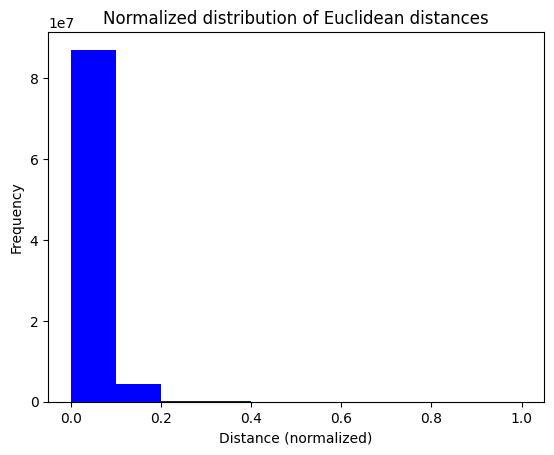

(9580, 9580)

In [68]:
unlabeled_distances = cdist(unlabeled_X, unlabeled_X)

# Normalize the distances
max_distance = np.max(unlabeled_distances)
unlabeled_normalized_distances = unlabeled_distances / max_distance

# Plot the normalized distribution of distances using a histogram
plt.hist(unlabeled_normalized_distances.flatten(), bins=10, color='blue')

# Set the x and y axis labels and title
plt.xlabel('Distance (normalized)')
plt.ylabel('Frequency')
plt.title('Normalized distribution of Euclidean distances')

# Show the plot
plt.show()

unlabeled_distances.shape


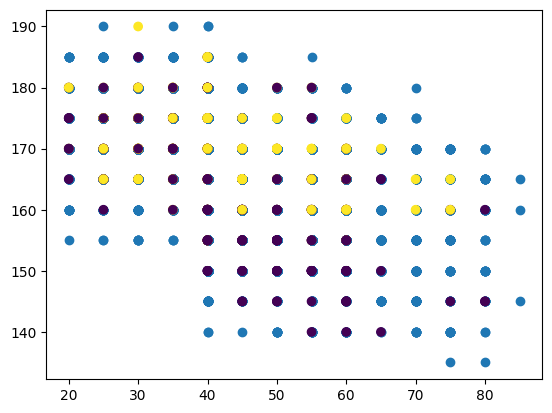

In [69]:
plt.scatter(unlabeled_X[:, 0], unlabeled_X[:, 1])
plt.scatter(labeled_X[:, 0], labeled_X[:, 1], c=y_labeled)

plt.show()

## Calculating Weights

For the weights, the following is the function that has been choosen:

$$
dist(a,b) = e^{-10 ||a-b||^2_2}
$$

In [70]:
def weight(dist):
    return math.e**(-10*dist**2)

In [71]:
%%time
print("Calculating weights between labeled points and unlabeled points")
labeled_unlabeled_weights = np.vectorize(weight)(labeled_normalized_distances)
print('Done')

print("Calculating weights between unlabeled points and unlabeled points")
unlabeled_unlabeled_weights = np.vectorize(weight)(unlabeled_normalized_distances)
print('Done')

Calculating weights between labeled points and unlabeled points
Done
Calculating weights between unlabeled points and unlabeled points
Done
CPU times: user 48 s, sys: 11.5 s, total: 59.5 s
Wall time: 1min 9s


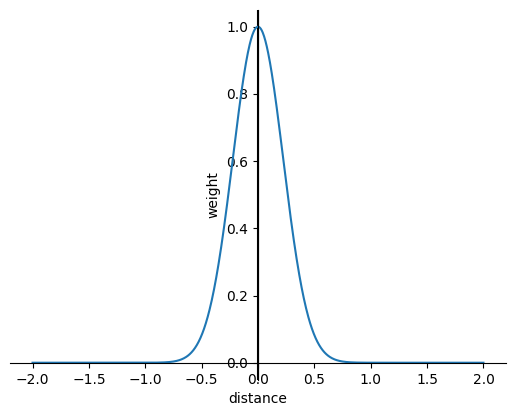

In [72]:
X = np.linspace(-2, 2, 1000)
plt.figure(dpi=100)
ax = plt.gca()
ax.legend_= None
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.set_ylabel('weight')
ax.set_xlabel('distance')
ax.axvline(x=0, color='k')
ax.plot(X, [weight(d) for d in X], label="asd")

The following are two implementations of the loss function:
$$
f(y) = \sum_{i=0}^l\sum_{j=0}^u w_{ij}(y^j -\bar{y}^i)^2 + \frac{1}{2} \sum_{i=0}^u\sum_{j=0}^u \bar{w}_{ij}(y^j -y^i)^2
$$
the following function is using linear algebra and Numpy to calcolate it, in order to have decent performance

In [73]:
def loss(labeled, unlabeled):
    Y = np.copy(unlabeled).astype("float64").reshape((-1,1))
    Y_bar = np.copy(labeled).astype("float64").reshape((-1,1))

    Y_minus_Y_bar = Y-Y_bar.T
    Y_minus_Y_bar_sq = np.power(Y_minus_Y_bar, 2)
    labeled_unlabeled_loss_matrix = Y_minus_Y_bar_sq * labeled_unlabeled_weights.T
    labeled_unlabeled_loss = np.sum(labeled_unlabeled_loss_matrix)

    Y_minus_Y = Y-Y.T
    Y_minus_Y_sq = np.power(Y_minus_Y, 2)
    unlabeled_unlabeled_loss_matrix = Y_minus_Y_sq * unlabeled_unlabeled_weights.T
    unlabeled_unlabeled_loss = np.sum(unlabeled_unlabeled_loss_matrix)

    return labeled_unlabeled_loss + unlabeled_unlabeled_loss/2

The following is a function used to calcolate the accuracy, comparing the targets and the current estimation (it's necessary in order to take care of the fact that the current is composed by number in $R \in\ [-1, 1]$ where the target is in $\{-1, 1\}$)

In [74]:
def accuracy_round(current):
    return np.sum(
        np.equal(
            (current/2 + .5).round() * 2 - 1,
            y_unlabeled_target
        )
    ) / len(y_unlabeled_target)
max_loss = np.sum(labeled_unlabeled_weights) * 4 + np.sum(unlabeled_unlabeled_weights) * 2
def accuracy_loss(current):
    return 1 - loss(y_labeled, current) / max_loss

initial_distance = np.linalg.norm(y_unlabeled_initial - y_unlabeled_target, ord=2)
def accuracy_norm(current):
    current_distance = np.linalg.norm(current - y_unlabeled_target, ord=2)
    return 1 - current_distance / initial_distance

def accuracy(current):
    return accuracy_round(current) #loss(y_labeled, current)

Those functions are used to calculate the Hessian matrix and the Lipschitz constat for the whole problem, and for the single variable.
The Hessian is calculated as follows:
$$
\begin{align*}
\text{with: } k\neq j \rightarrow \nabla_{y^jy^k}f(j) &=\bar{w}_{kj}\\
\text{with: } k = j \rightarrow \nabla_{y^jy^j}f(j) &= 2(\sum_{i=0}^lw_{ij}) + (\sum_{i=0}^u\bar{w}_{ij}) - \bar{w}_{jj} \\
\end{align*}
\\
\[
  Hessian_{n\times n} =
  \left[ {\begin{array}{cccc}
    2(\sum_{i=0}^lw_{i1}) + (\sum_{i=0}^u\bar{w}_{i1}) - \bar{w}_{11} & -\bar{w}_{12} & \cdots & -\bar{w}_{1n}\\
    -\bar{w}_{21} & 2(\sum_{i=0}^lw_{i2}) + (\sum_{i=0}^u\bar{w}_{i2}) - \bar{w}_{22} & \cdots & -\bar{w}_{2n}\\
    \vdots & \vdots & \ddots & \vdots\\
    -\bar{w}_{n1} & -\bar{w}_{n2} & \cdots & 2(\sum_{i=0}^lw_{in}) + (\sum_{i=0}^u\bar{w}_{in}) - \bar{w}_{nn}\\
  \end{array} } \right]
\]

$$


### Hessian and constants

In [75]:
%%time
def hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled):
    mat = np.copy(-w_unlabeled_unlabeled)
    for i in range(len(y_unlabeled_target)):
        if i % (len(y_unlabeled_target) * OUTPUT_STEP) == 0 :
            print(f"{int(i/len(y_unlabeled_target)*100):02}% ... ", end="")
        mat[i][i] = 2 * np.sum(labeled_unlabeled_weights[:,i]) + np.sum(unlabeled_unlabeled_weights[:,i]) - unlabeled_unlabeled_weights[i][i]
    print()
    return mat

def estimate_lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]
def estimate_degree_strongly_convex(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]

if USE_LIPSCHITZ_CONSTANT:
    print("Calculating the Hessian matrix")
    hessian = hessian_matrix(unlabeled_unlabeled_weights, labeled_unlabeled_weights)
    print("Calculating sigma (strongly convex)")
    sigma = estimate_degree_strongly_convex(hessian)
    strongly_convex = sigma > 0
    print(f"Sigma: {sigma}, {'' if strongly_convex else 'not'} strongly convex")
    print("Estimating Lipschitz constant for the whole function")
    L = estimate_lipschitz_constant(hessian)
    print(f"Lipschitz constant: {L}")
    print("Estimating Lipschitz constant for each single variable")
    Li = np.array([hessian[i][i] for i in range(len(hessian))], dtype='float64') \
        if OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM \
        else np.repeat(L, len(hessian))
else:
    print("Using fixed step size")
    sigma = 0
    strongly_convex = False
    L = 1/STEP_SIZE
    Li = np.repeat(L, len(y_unlabeled_target))
print("Done")

Calculating the Hessian matrix
00% ... 10% ... 20% ... 30% ... 40% ... 50% ... 60% ... 70% ... 80% ... 90% ... 
Calculating sigma (strongly convex)
Sigma: 4.845156137354792,  strongly convex
Estimating Lipschitz constant for the whole function
Lipschitz constant: 10247.722370226145
Estimating Lipschitz constant for each single variable
Done
CPU times: user 9min 42s, sys: 3min 19s, total: 13min 1s
Wall time: 2min 38s


Following are some constant that are going to be used in the gradient, since it can rewritten in a format which allows to avoid having to redo those calculation each time

In [76]:
print("Calculating coefficients of the gradient")
sum_row_label_unlabel = np.sum(labeled_unlabeled_weights, axis=0).reshape((-1,1))
sum_row_unlabel_unlabel = np.sum(unlabeled_unlabeled_weights, axis=0).reshape((-1,1))
grad_first_coeff_vec = (2 * sum_row_label_unlabel + sum_row_unlabel_unlabel)
grad_second_coeff_vec = 2 * np.multiply(
    y_labeled.reshape((-1,1)),
    labeled_unlabeled_weights
).sum(0).reshape((-1,1))
print("Done")

Calculating coefficients of the gradient
Done


## Gradient Descent Methods

Following is the function used to calculate the gradient, which for a single variable is:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})y^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

In [77]:
def gradient(unlabeled):
    unlabeled = unlabeled.reshape((-1,1))
    third_coeff = np.multiply(
        unlabeled,
        unlabeled_unlabeled_weights
    ).sum(0).reshape((-1,1))
    return (grad_first_coeff_vec * unlabeled - grad_second_coeff_vec - third_coeff).reshape((-1,))

### Gradient Descent

Creating a copy of the defined initialization, in order to have the same also in the following algorithms

In [78]:
y_unlabeled_gd = np.copy(y_unlabeled_initial)

In [79]:
%%time
ticks_gd = [0]
accuracies_gd = [accuracy(y_unlabeled_gd)]
losses_gd = [loss(y_labeled, y_unlabeled_gd)]
init_time = time.time() * 1000

for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd = y_unlabeled_gd - 1/L * grad
    accuracies_gd.append(accuracy(y_unlabeled_gd))
    losses_gd.append(loss(y_labeled, y_unlabeled_gd))
    ticks_gd.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd):05.2f}")
print(f"""
Final accuracy: {round(accuracies_gd[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd))}
Loss: {loss(y_labeled, y_unlabeled_gd)}
""")

00% - iter 0 / 60 - final accuracy 52.82% - loss 3946403.45
10% - iter 6 / 60 - final accuracy 64.06% - loss 3792444.27
20% - iter 12 / 60 - final accuracy 64.06% - loss 3763878.61
30% - iter 18 / 60 - final accuracy 64.06% - loss 3753286.28
40% - iter 24 / 60 - final accuracy 64.06% - loss 3749339.87
50% - iter 30 / 60 - final accuracy 64.06% - loss 3747866.35
60% - iter 36 / 60 - final accuracy 64.06% - loss 3747314.33
70% - iter 42 / 60 - final accuracy 64.06% - loss 3747106.01
80% - iter 48 / 60 - final accuracy 64.06% - loss 3747026.03
90% - iter 54 / 60 - final accuracy 64.06% - loss 3746994.06

Final accuracy: 64.06%
Norm gradient: 121.54058438812511
Loss: 3746981.820817752

CPU times: user 5min 23s, sys: 2min 15s, total: 7min 39s
Wall time: 9min 10s


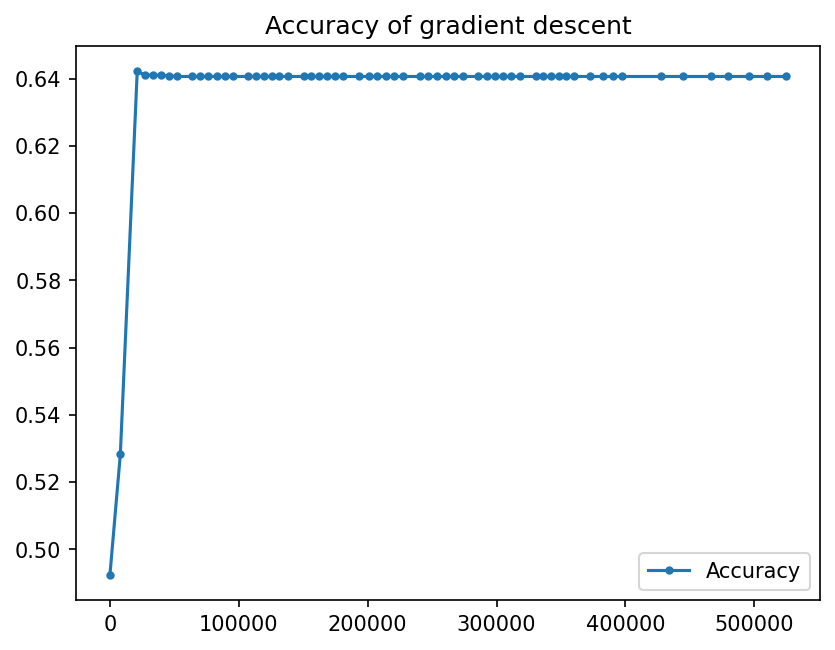

In [80]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of gradient descent")
plt.plot(ticks_gd, accuracies_gd, marker='.')
plt.legend(["Accuracy"])

### Gradient Descent with improved rate

This implementation of the GD algorithm with use:
$$
\alpha_k = $\frac{2}{L+sigma}$
$$
in case the problem is strongly convex

In [81]:
y_unlabeled_gd_improved = np.copy(y_unlabeled_initial)

In [82]:
%%time
ticks_gd_improved = [0]
accuracies_gd_improved = [accuracy(y_unlabeled_gd_improved)]
losses_gd_improved = [loss(y_labeled, y_unlabeled_gd_improved)]
init_time = time.time() * 1000
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd_improved)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd_improved = y_unlabeled_gd_improved - (2 if strongly_convex else 1)/(L + (sigma if strongly_convex else 0)) * grad
    accuracies_gd_improved.append(accuracy(y_unlabeled_gd_improved))
    losses_gd_improved.append(loss(y_labeled, y_unlabeled_gd_improved))
    ticks_gd_improved.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd_improved[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd_improved):05.2f}")
print(f"""
Final accuracy: {round(accuracies_gd_improved[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_improved))}
Loss: {loss(y_labeled, y_unlabeled_gd_improved)}
""")

00% - iter 0 / 60 - final accuracy 50.80% - loss 91372641.00
10% - iter 6 / 60 - final accuracy 50.65% - loss 70616955.39
20% - iter 12 / 60 - final accuracy 50.14% - loss 57588578.72
30% - iter 18 / 60 - final accuracy 49.85% - loss 48234271.71
40% - iter 24 / 60 - final accuracy 49.72% - loss 41140031.51
50% - iter 30 / 60 - final accuracy 49.47% - loss 35586315.39
60% - iter 36 / 60 - final accuracy 49.55% - loss 31142101.19
70% - iter 42 / 60 - final accuracy 50.00% - loss 27525667.97
80% - iter 48 / 60 - final accuracy 50.17% - loss 24542671.93
90% - iter 54 / 60 - final accuracy 50.89% - loss 22053977.74

Final accuracy: 50.51%
Norm gradient: 419237.14286475925
Loss: 20282945.546732854

CPU times: user 5min 52s, sys: 3min 11s, total: 9min 4s
Wall time: 11min 45s


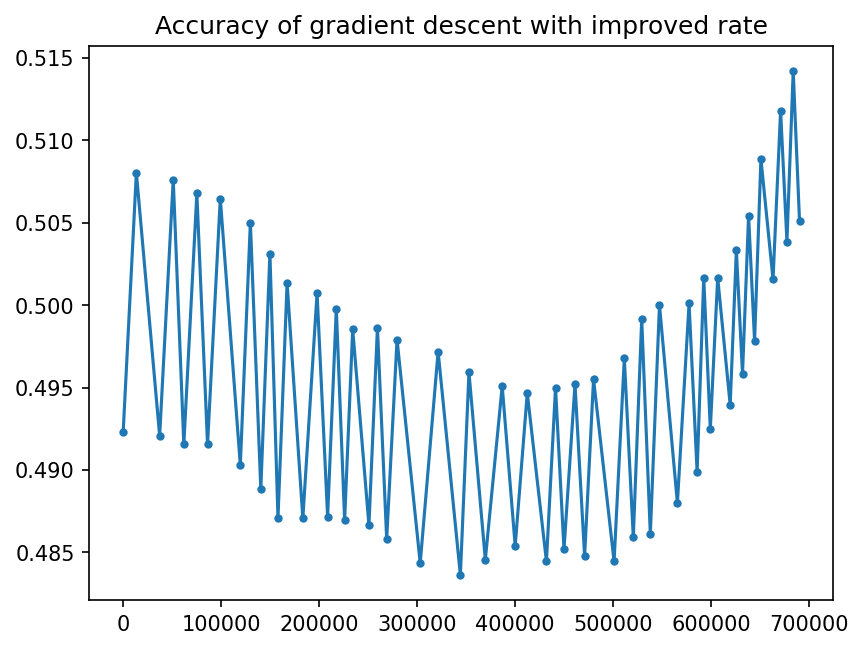

In [83]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of gradient descent with improved rate")
plt.plot(ticks_gd_improved, accuracies_gd_improved, marker='.')

### Heavy ball

In [84]:
y_unlabeled_gd_hb_previous = y_unlabeled_gd_hb = np.copy(y_unlabeled_initial)

In [85]:
%%time
ticks_gd_hb = [0]
accuracies_gd_hb = [accuracy(y_unlabeled_gd_hb)]
losses_gd_hb = [loss(y_labeled, y_unlabeled_gd_hb)]
init_time = time.time() * 1000
Alpha = 1
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd_hb)
    if EPSILON >= np.linalg.norm(grad):
        break

    new_Alpha = (1 + math.sqrt(1 + 4 * Alpha**2))/2
    Beta = (Alpha - 1) / new_Alpha
    Alpha = new_Alpha
    momentum = Beta * (y_unlabeled_gd_hb - y_unlabeled_gd_hb_previous)

    old_y_unlabeled_gd_hb = np.copy(y_unlabeled_gd_hb)
    y_unlabeled_gd_hb = y_unlabeled_gd_hb - 1/L * grad + momentum
    y_unlabeled_gd_hb_previous = old_y_unlabeled_gd_hb

    accuracies_gd_hb.append(accuracy(y_unlabeled_gd_hb))
    losses_gd_hb.append(loss(y_labeled, y_unlabeled_gd_hb))
    ticks_gd_hb.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd_hb[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd_hb):05.2f}")

print(f"""
Final accuracy: {round(accuracies_gd_hb[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_hb))}
Loss: {loss(y_labeled, y_unlabeled_gd_hb)}
""")

00% - iter 0 / 60 - final accuracy 52.82% - loss 3946403.45
10% - iter 6 / 60 - final accuracy 64.07% - loss 4123990.37
20% - iter 12 / 60 - final accuracy 64.06% - loss 3881743.18
30% - iter 18 / 60 - final accuracy 64.06% - loss 3803391.66
40% - iter 24 / 60 - final accuracy 64.06% - loss 3774634.78
50% - iter 30 / 60 - final accuracy 64.06% - loss 3761513.36
60% - iter 36 / 60 - final accuracy 64.06% - loss 3755582.58
70% - iter 42 / 60 - final accuracy 64.05% - loss 3752112.98
80% - iter 48 / 60 - final accuracy 64.05% - loss 3750379.87
90% - iter 54 / 60 - final accuracy 64.05% - loss 3749193.83

Final accuracy: 64.05%
Norm gradient: 4404.065939945797
Loss: 3748814.890926069

CPU times: user 5min 7s, sys: 1min 54s, total: 7min 1s
Wall time: 7min 52s


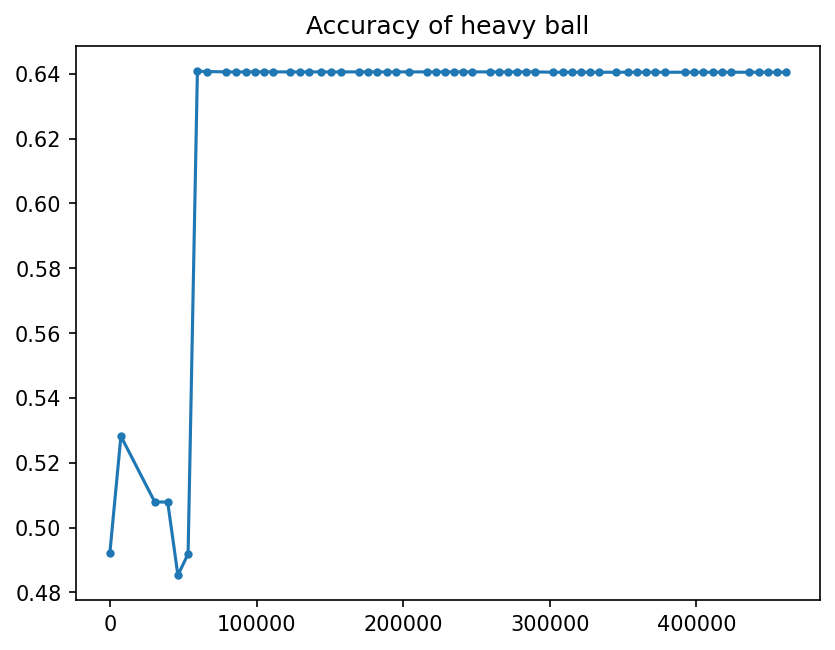

In [86]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of heavy ball")
plt.plot(ticks_gd_hb, accuracies_gd_hb, marker='.')

### Accelerated Gradient

In [87]:
y_unlabeled_gd_accelerated_previous = y_unlabeled_gd_accelerated = np.copy(y_unlabeled_initial)

In [88]:
%%time
ticks_gd_accelerated = [0]
accuracies_gd_accelerated = [accuracy(y_unlabeled_gd_accelerated)]
init_time = time.time() * 1000
losses_gd_accelerated = [loss(y_labeled, y_unlabeled_gd_accelerated)]
Alpha = 1
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")
    start = time.process_time()
    new_Alpha = (1 + math.sqrt(1 + 4 * Alpha**2))/2
    Beta = (Alpha - 1) / new_Alpha
    Alpha = new_Alpha
    new_position = y_unlabeled_gd_accelerated + Beta * (y_unlabeled_gd_accelerated - y_unlabeled_gd_accelerated_previous)
    grad = gradient(new_position)
    if EPSILON >= np.linalg.norm(grad):
        break

    old_y_unlabeled_gd_accelerated = np.copy(y_unlabeled_gd_accelerated)
    y_unlabeled_gd_accelerated = new_position - 1/L * grad
    y_unlabeled_gd_accelerated_previous = old_y_unlabeled_gd_accelerated

    accuracies_gd_accelerated.append(accuracy(y_unlabeled_gd_accelerated))
    losses_gd_accelerated.append(loss(y_labeled, y_unlabeled_gd_accelerated))
    ticks_gd_accelerated.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd_accelerated[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd_accelerated):05.2f}")

print(f"""
Final accuracy: {round(accuracies_gd_accelerated[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_accelerated))}
Loss: {loss(y_labeled, y_unlabeled_gd_accelerated)}
""")

00% - iter 0 / 60 - final accuracy 52.82% - loss 3946403.45
10% - iter 6 / 60 - final accuracy 64.06% - loss 3760468.87
20% - iter 12 / 60 - final accuracy 64.06% - loss 3747353.39
30% - iter 18 / 60 - final accuracy 64.06% - loss 3747300.43
40% - iter 24 / 60 - final accuracy 64.06% - loss 3747005.17
50% - iter 30 / 60 - final accuracy 64.06% - loss 3746962.37
60% - iter 36 / 60 - final accuracy 64.06% - loss 3746944.86
70% - iter 42 / 60 - final accuracy 64.05% - loss 3746932.88
80% - iter 48 / 60 - final accuracy 64.05% - loss 3746933.57
90% - iter 54 / 60 - final accuracy 64.05% - loss 3746931.34

Final accuracy: 64.05%
Norm gradient: 31.559686844869052
Loss: 3746931.752805249

CPU times: user 5min 2s, sys: 1min 46s, total: 6min 49s
Wall time: 7min 30s


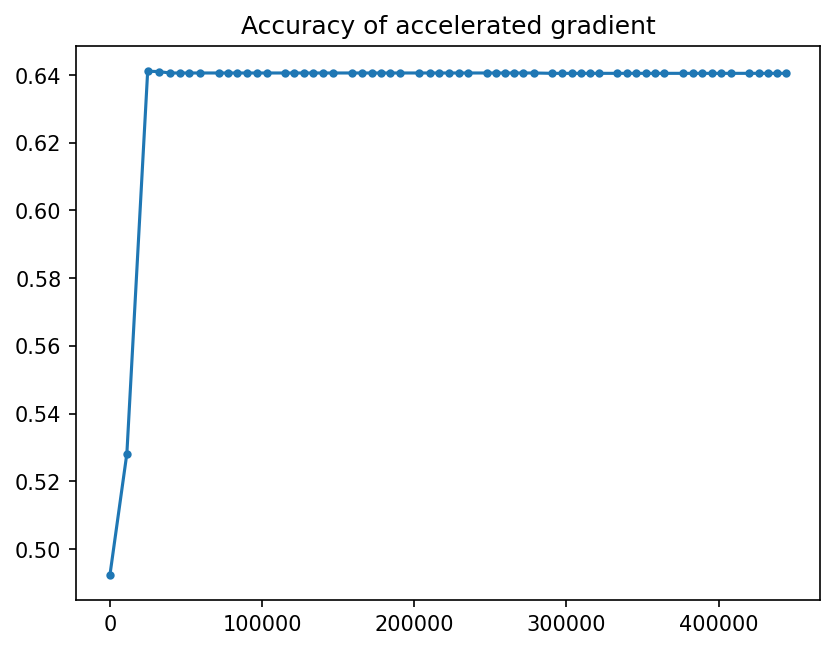

In [89]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of accelerated gradient")
plt.plot(ticks_gd_accelerated, accuracies_gd_accelerated, marker='.')

## Block Coordinate Gradient Method

Following is the function used to find the derivative in respect to a single variable:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})\bar{y}^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

In [90]:
def derivative(unlabeled, j):
    return grad_first_coeff_vec[j] * unlabeled[j] - \
           grad_second_coeff_vec[j] - \
           np.matmul(w_unlabeled_unlabeled[:,j], unlabeled.T)

def derivative_iterative(labeled, unlabeled, j):
    tot = 0
    for i in range(len(labeled)):
        tot += 2*w_labeled_unlabeled[i][j] * (unlabeled[j] - labeled[i])
    for i in range(len(unlabeled)):
        tot += w_unlabeled_unlabeled[i][j] * (unlabeled[j] - unlabeled[i])
    return tot

def update_gradient(previous_grad, Li, index):
    global unlabeled_unlabeled_weights, grad_first_coeff_vec
    step = 1/Li[index] * previous_grad[index]
    new_grad = np.copy(previous_grad)
    new_grad += unlabeled_unlabeled_weights[index] * step
    new_grad[index] -= grad_first_coeff_vec[index] * step
    return step, new_grad

### Randomized

In [91]:
y_unlabeled_bcgd_random = np.copy(y_unlabeled_initial).astype("float64")

In [92]:
%%time
ticks_bcgd_random= [0]
accuracies_bcgd_random= [accuracy(y_unlabeled_bcgd_random)]
losses_bcgm_random = [loss(y_labeled, y_unlabeled_bcgd_random)]

optimized_sampling_probabilities = np.copy(Li) / np.sum(Li)
previous_grad_random = gradient(y_unlabeled_bcgd_random)
max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_random)
indexes = np.random.choice(len(y_unlabeled_bcgd_random), max_iterations, p=optimized_sampling_probabilities)[0] \
    if OPTIMIZE_RANDOM else np.random.randint(0, len(y_unlabeled_bcgd_random), max_iterations)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = indexes[i]

    step, new_grad = update_gradient(previous_grad_random, Li, index)
    y_unlabeled_bcgd_random[index] = y_unlabeled_bcgd_random[index] - step
    previous_grad_random = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_random):
        break

    if (i+1) % len(y_unlabeled_target) == 0:

        accuracies_bcgd_random.append(accuracy(y_unlabeled_bcgd_random))
        losses_bcgm_random.append(loss(y_labeled, y_unlabeled_bcgd_random))
        ticks_bcgd_random.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_random[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_random):05.2f}")

print(f"""
Final accuracy: {round(accuracies_bcgd_random[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_random))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_random)}
""")

00% - iter 0 / 574800 - final accuracy 49.23% - loss 96626942.02
10% - iter 57480 / 574800 - final accuracy 63.98% - loss 4047242.79
20% - iter 114960 / 574800 - final accuracy 64.06% - loss 3774338.65
30% - iter 172440 / 574800 - final accuracy 64.06% - loss 3757606.31
40% - iter 229920 / 574800 - final accuracy 64.06% - loss 3751076.60
50% - iter 287400 / 574800 - final accuracy 64.06% - loss 3748592.17
60% - iter 344880 / 574800 - final accuracy 64.06% - loss 3747602.56
70% - iter 402360 / 574800 - final accuracy 64.06% - loss 3747229.73
80% - iter 459840 / 574800 - final accuracy 64.06% - loss 3747079.26
90% - iter 517320 / 574800 - final accuracy 64.06% - loss 3747019.20

Final accuracy: 64.06%
Norm gradient: 210.01830140050242
Loss: 3746993.769639619

CPU times: user 5min 19s, sys: 1min 53s, total: 7min 12s
Wall time: 8min 18s


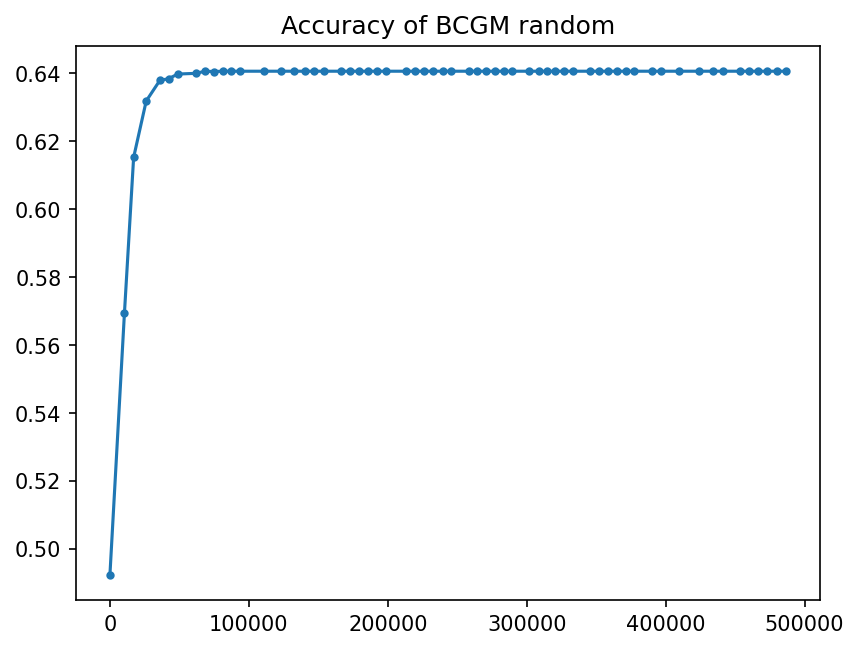

In [93]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of BCGM random")
plt.plot(ticks_bcgd_random, accuracies_bcgd_random, marker='.')

### Cyclic

In [94]:
y_unlabeled_bcgd_cyclic = np.copy(y_unlabeled_initial).astype("float64")

In [95]:
%%time
ticks_bcgd_cyclic= [0]
accuracies_bcgd_cyclic= [accuracy(y_unlabeled_bcgd_cyclic)]
losses_bcgm_cyclic = [loss(y_labeled, y_unlabeled_bcgd_cyclic)]

previous_grad_cyclic = gradient(y_unlabeled_bcgd_cyclic)
max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_cyclic)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = i % len(y_unlabeled_bcgd_cyclic)

    step, new_grad = update_gradient(previous_grad_cyclic, Li, index)
    y_unlabeled_bcgd_cyclic[index] = y_unlabeled_bcgd_cyclic[index] - step
    previous_grad_cyclic = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_cyclic):
        break

    if (i+1) % len(y_unlabeled_target) == 0:

        accuracies_bcgd_cyclic.append(accuracy(y_unlabeled_bcgd_cyclic))
        losses_bcgm_cyclic.append(loss(y_labeled, y_unlabeled_bcgd_cyclic))
        ticks_bcgd_cyclic.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_cyclic[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_cyclic):05.2f}")


print(f"""
Final accuracy: {round(accuracies_bcgd_cyclic[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_cyclic))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_cyclic)}
""")

00% - iter 0 / 574800 - final accuracy 49.23% - loss 96627167.59
10% - iter 57480 / 574800 - final accuracy 64.06% - loss 3770470.10
20% - iter 114960 / 574800 - final accuracy 64.06% - loss 3750440.41
30% - iter 172440 / 574800 - final accuracy 64.06% - loss 3747508.55
40% - iter 229920 / 574800 - final accuracy 64.06% - loss 3747072.53
50% - iter 287400 / 574800 - final accuracy 64.06% - loss 3747004.15
60% - iter 344880 / 574800 - final accuracy 64.06% - loss 3746990.27
70% - iter 402360 / 574800 - final accuracy 64.06% - loss 3746984.72
80% - iter 459840 / 574800 - final accuracy 64.06% - loss 3746980.67
90% - iter 517320 / 574800 - final accuracy 64.06% - loss 3746977.08

Final accuracy: 64.06%
Norm gradient: 52.31511066343797
Loss: 3746973.7750635385

CPU times: user 5min 10s, sys: 1min 36s, total: 6min 46s
Wall time: 7min 25s


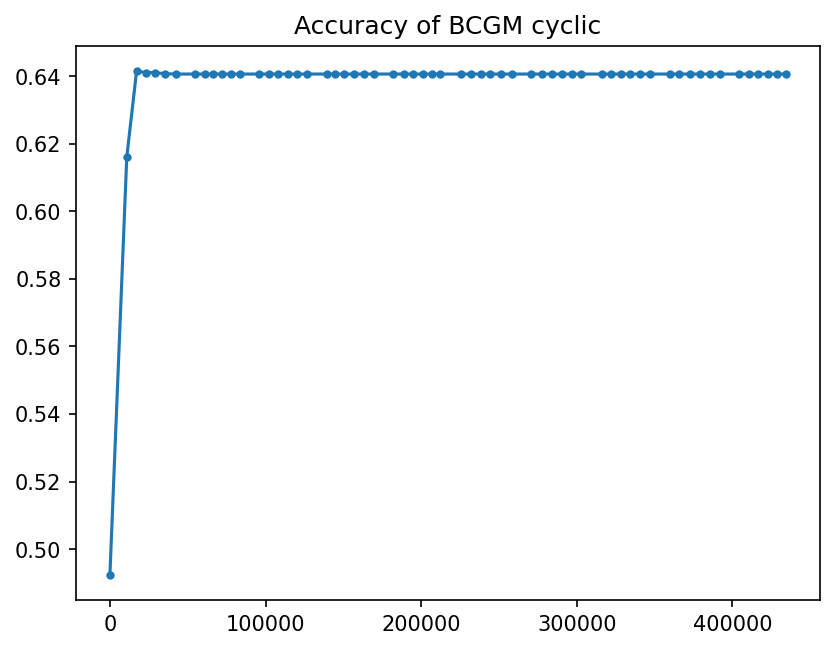

In [96]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of BCGM cyclic")
plt.plot(ticks_bcgd_cyclic, accuracies_bcgd_cyclic, marker='.')

### Gauss-Southwell

In [97]:
y_unlabeled_bcgd_gs = np.copy(y_unlabeled_initial).astype("float64")

In [98]:
%%time
ticks_bcgd_gs = [0]
accuracies_bcgd_gs = [accuracy(y_unlabeled_bcgd_gs)]
losses_bcgm_gs = [loss(y_labeled, y_unlabeled_bcgd_gs)]

max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_random)
previous_grad_gs = gradient(y_unlabeled_bcgd_gs)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = np.argmax(np.abs(previous_grad_gs))

    step, new_grad = update_gradient(previous_grad_gs, Li, index)
    y_unlabeled_bcgd_gs[index] = y_unlabeled_bcgd_gs[index] - step
    previous_grad_gs = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_gs):
        break

    if (i+1) % len(y_unlabeled_target) == 0:

        accuracies_bcgd_gs.append(accuracy(y_unlabeled_bcgd_gs))
        losses_bcgm_gs.append(loss(y_labeled, y_unlabeled_bcgd_gs))
        ticks_bcgd_gs.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_gs[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_gs):05.2f}")


print(f"""
Final accuracy: {round(accuracies_bcgd_gs[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_gs))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_gs)}
""")

00% - iter 0 / 574800 - final accuracy 49.23% - loss 96627014.28
10% - iter 57480 / 574800 - final accuracy 64.06% - loss 4008618.34
20% - iter 114960 / 574800 - final accuracy 64.06% - loss 3785567.19
30% - iter 172440 / 574800 - final accuracy 64.06% - loss 3752667.83
40% - iter 229920 / 574800 - final accuracy 64.06% - loss 3747779.52
50% - iter 287400 / 574800 - final accuracy 64.05% - loss 3747057.13
60% - iter 344880 / 574800 - final accuracy 64.05% - loss 3746947.63
70% - iter 402360 / 574800 - final accuracy 64.05% - loss 3746929.51
80% - iter 459840 / 574800 - final accuracy 64.06% - loss 3746926.52
90% - iter 517320 / 574800 - final accuracy 64.06% - loss 3746926.02

Final accuracy: 64.06%
Norm gradient: 4.953085991261803
Loss: 3746925.9600480073

CPU times: user 5min 23s, sys: 1min 40s, total: 7min 4s
Wall time: 8min 10s


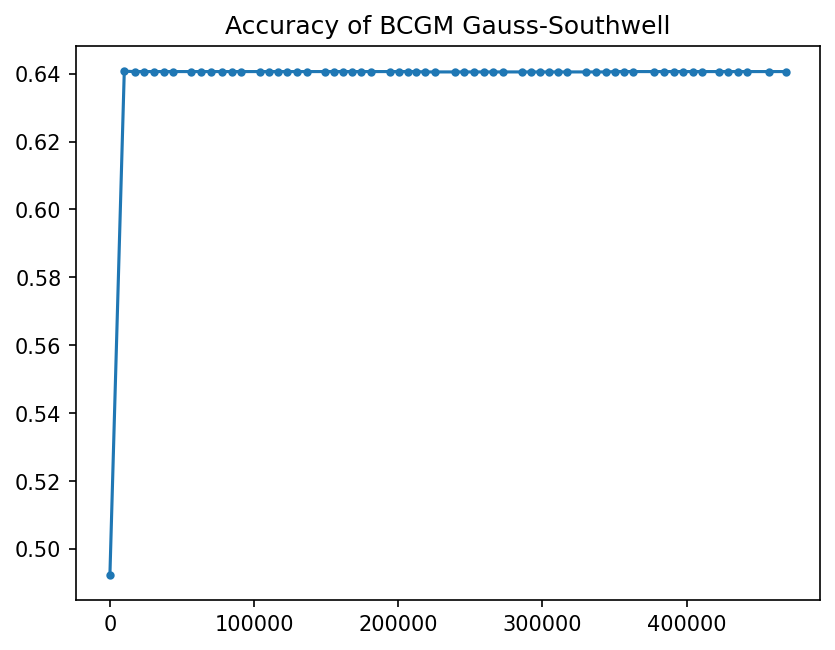

In [99]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of BCGM Gauss-Southwell")
plt.plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')

### Loss

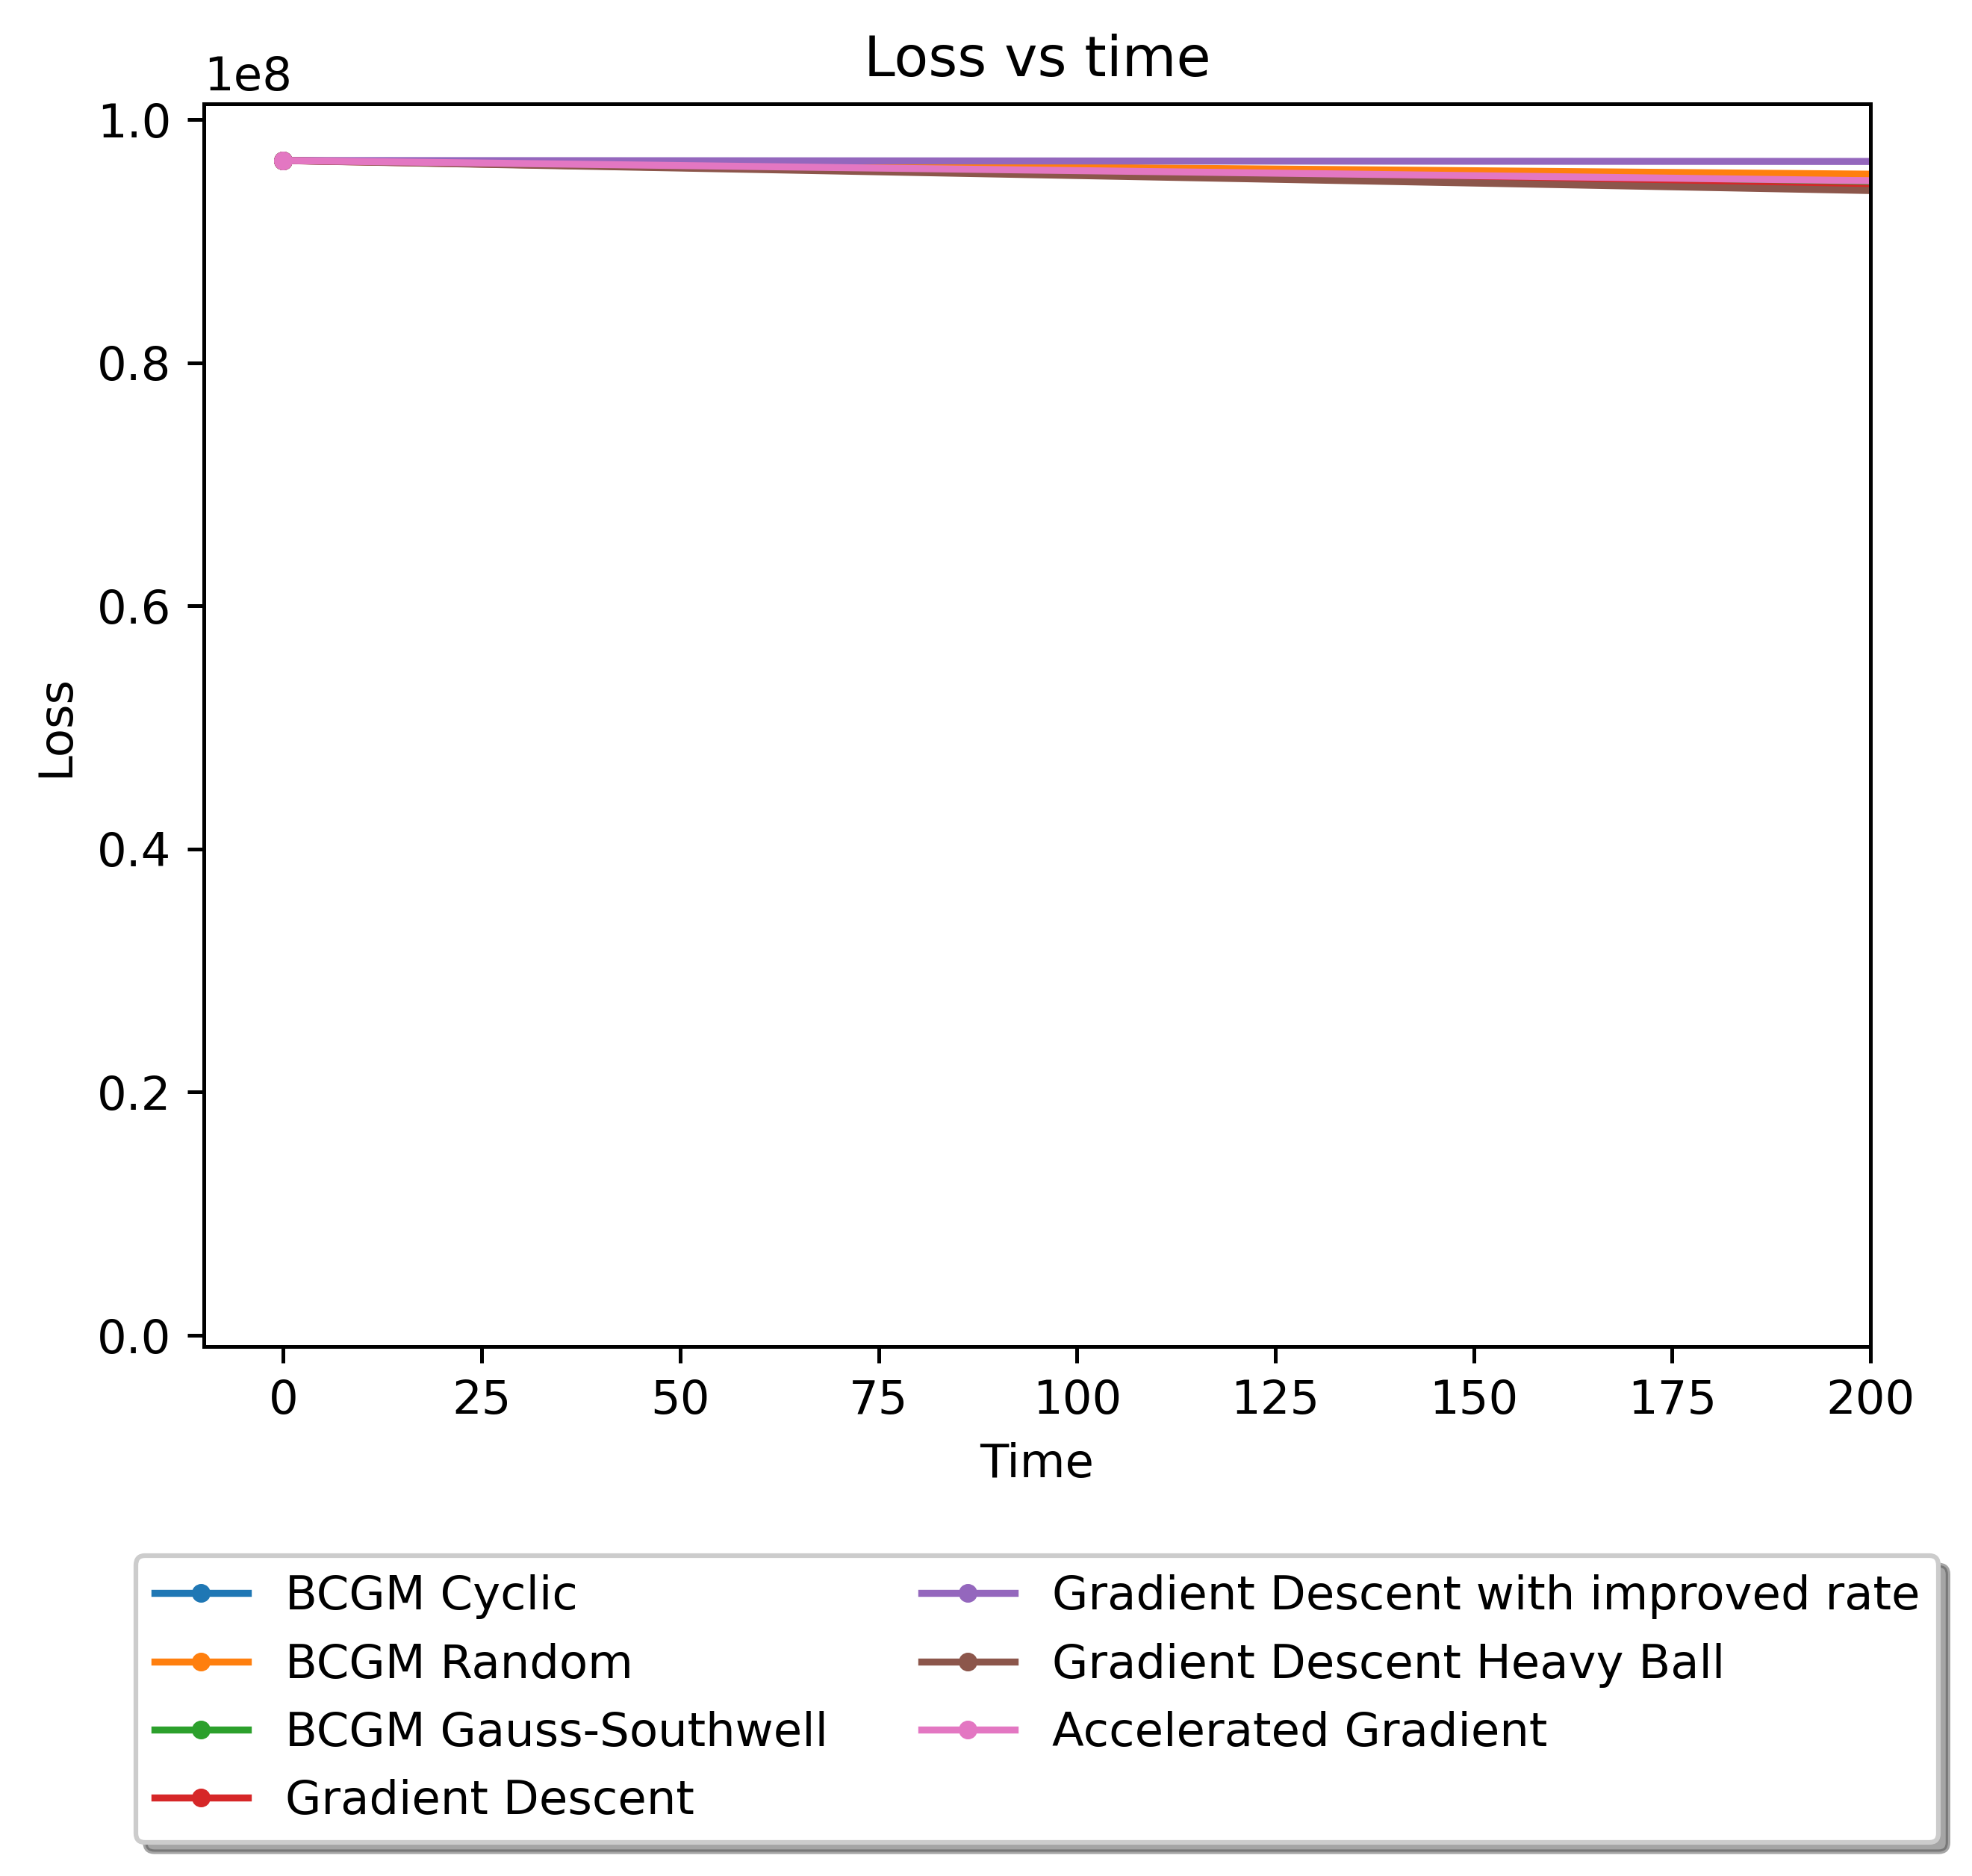

In [100]:
plt.figure(dpi=PLOT_DPI*3)
plt.plot(ticks_bcgd_cyclic , losses_bcgm_cyclic, marker='.')
plt.plot(ticks_bcgd_random , losses_bcgm_random, marker='.')
plt.plot(ticks_bcgd_gs , losses_bcgm_gs, marker='.')
plt.plot(ticks_gd , losses_gd, marker='.')
plt.plot(ticks_gd_improved , losses_gd_improved, marker='.')
plt.plot(ticks_gd_hb , losses_gd_hb, marker='.')
plt.plot(ticks_gd_accelerated , losses_gd_accelerated, marker='.')

plt.title("Loss vs time")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.xlim(-10,200)
plt.legend(
    [
        'BCGM Cyclic',
        'BCGM Random',
        'BCGM Gauss-Southwell',
        'Gradient Descent',
        'Gradient Descent with improved rate',
        'Gradient Descent Heavy Ball',
        "Accelerated Gradient"
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2

)